<a href="https://colab.research.google.com/github/mxn170019/Ieee_Fraud-Detection-Kaggle-competition/blob/master/ieeeFraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Dictionary


## Transaction Table *
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
## Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

# Identity Table *
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

## Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

#import required libraries

In [0]:

import os
import glob
from pathlib import Path
import zipfile

import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

from ipywidgets import widgets, interactive
from ipykernel.pylab.backend_inline import flush_figures




pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50000)

#data directory

In [6]:
# Attaching Drive to colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mxn170019","key":"3a67e29bb92b34ac3c0d8fadd0dfb4bc"}'}

In [7]:
!pip install -q kaggle
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
# !kaggle datasets list -s skin
!kaggle competitions download -c ieee-fraud-detection

-rw-r--r-- 1 root root 65 Sep 28 21:21 kaggle.json
 78% 41.0M/52.5M [00:00<00:00, 43.1MB/s]
100% 52.5M/52.5M [00:00<00:00, 82.8MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 98.9MB/s]
 85% 40.0M/47.3M [00:00<00:00, 68.4MB/s]
100% 47.3M/47.3M [00:00<00:00, 80.7MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 202MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 165MB/s]


In [0]:
ls = glob.glob("*.zip")
for item in ls:
  zipfile.ZipFile(item).extractall()

!rm *.zip

In [0]:
# Define path to the data directory
data_dir = Path('/content')

train_transaction_dir = data_dir / 'train_transaction.csv'
train_identity_dir = data_dir / 'train_identity.csv'

test_transaction_dir = data_dir / 'test_transaction.csv'
test_identity_dir = data_dir / 'test_identity.csv'

sample_submission = data_dir/'sample_submission.csv'

#EDA - Transaction Data

In [10]:
#let see how should be the submission file
sample_submission = pd.read_csv(sample_submission)
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [11]:
#read train_transaction data
train_tran_df = pd.read_csv(train_transaction_dir)
train_tran_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [12]:
train_tran_df.shape

(590540, 394)

In [13]:
#read train_identity data
train_identity_df = pd.read_csv(train_identity_dir)
train_identity_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [14]:
train_identity_df.shape

(144233, 41)

In [15]:
#faud and non fraund franction
np.round(train_tran_df.isFraud.value_counts(normalize=True)*100,decimals=2) # this is a case of unbalanced data.

0    96.5
1     3.5
Name: isFraud, dtype: float64

In [16]:
#how many unique transaction ids we have?
print("Unique Transaction ids: ",len(train_tran_df.TransactionID.unique()))
print("data dim: ",train_tran_df.shape)

# no duplicates

Unique Transaction ids:  590540
data dim:  (590540, 394)


In [0]:
#Time and day are imprtant factors to identify 
train_tran_df['Transaction_dow'] = np.floor((train_tran_df['TransactionDT'] / (3600 * 24)-1) % 7)#day of a week from some referance day
train_tran_df['Transaction_hour'] = np.floor(train_tran_df['TransactionDT'] / 3600) % 24 # hour of the day

In [18]:
day_fraud = pd.crosstab(train_tran_df['Transaction_dow'],train_tran_df.isFraud).transpose()
day_fraud

Transaction_dow,0.0,1.0,2.0,3.0,4.0,5.0,6.0
isFraud,,,,,,,
0,94952,76871,67720,82746,82012,82410,83166
1,3550,2963,2503,2687,2803,2946,3211


In [19]:
pd.crosstab(train_tran_df['Transaction_hour'],train_tran_df.isFraud).transpose()

Transaction_hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
isFraud,,,,,,,,,,,,,,,,,,,,,,,,
0,36609,31770,25730,20005,14069,9019,5540,3311,2350,2256,3434,6562,12072,19850,27642,32999,37556,39439,40172,40652,40350,40225,39794,38471
1,1186,1027,1002,797,770,682,467,393,241,223,193,265,379,465,686,860,1142,1284,1467,1463,1432,1416,1345,1478


In [20]:
#EDA Numerical and Categorical columns
transaction_data_columns = train_tran_df.columns
numericCols = train_tran_df._get_numeric_data().columns

categoricalCols = list(set(transaction_data_columns) - set(numericCols))
print('The categorical columns in transaction data are: ',categoricalCols)

The categorical columns in transaction data are:  ['P_emaildomain', 'M6', 'card6', 'M5', 'M4', 'M9', 'ProductCD', 'R_emaildomain', 'M3', 'M8', 'M7', 'card4', 'M2', 'M1']


In [0]:
# Transaction Amount vs fraud

X_Axis= widgets.Dropdown(options= numericCols)
Y_Axis= widgets.Dropdown(options= numericCols)

def plot_scatter(X_Axis,Y_Axis):                            
  plt.figure(figsize = (20,5))
  plt.subplot(1, 2, 1)
  sns.scatterplot(x = train_tran_df[X_Axis],y = train_tran_df[Y_Axis],hue = train_tran_df.isFraud)
  plt.subplot(1, 2, 2)
  sns.scatterplot(x = train_tran_df[Y_Axis],y =train_tran_df[X_Axis],hue = train_tran_df.isFraud)

In [27]:
%matplotlib inline
interactive(plot_scatter, X_Axis=X_Axis,Y_Axis=Y_Axis)

interactive(children=(Dropdown(description='X_Axis', index=3, options=('TransactionID', 'isFraud', 'Transactio…

In [0]:
X_Axis = widgets.Dropdown(options= numericCols)
BC_lambda = widgets.Dropdown(options= [0,-1,-2,-3,None])
def plot_hist_vs_transformed_hist(X_Axis,BC_lambda=BC_lambda):                            
  plt.subplot(1, 3, 1)
  (train_tran_df[X_Axis]).plot.hist(bins=50, figsize=(21, 5),color = 'red',alpha = 0.5 ,edgecolor = 'white',title = 'Without Transformation')
  
  plt.subplot(1, 3, 2)
  pd.Series(boxcox(train_tran_df[X_Axis],BC_lambda)[0]).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'BoxCox Transformation')
  plt.subplot(1, 3, 3)
  np.log(train_tran_df[X_Axis]+1).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'log Transformation')
  plt.show()

In [73]:
# %matplotlib inline
# interactive(plot_hist_vs_transformed_hist, X_Axis=X_Axis,BC_lambda=BC_lambda)



interactive(children=(Dropdown(description='X_Axis', options=('TransactionID', 'isFraud', 'TransactionDT', 'Tr…

In [0]:
num_Columns_Card = ['card1','card2','card3','card5']
num_Columns_addr = ['addr1','addr2']
num_Columns_dist = ['dist1','dist2']
num_Columns_C = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']
num_Columns_D = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']
num_Columns_V = train_tran_df.loc[:, 'V1':'V339'].columns

all_columns = [num_Columns_Card,num_Columns_addr,num_Columns_dist,num_Columns_C,num_Columns_D,num_Columns_V]

In [0]:
#Imputing Missing values
for i in all_columns:
  print(train_tran_df[i].isna().sum()/train_tran_df.shape[0]*100)
  print("*************"+"\n\n")

In [94]:
pandas_profiling.ProfileReport(train_tran_df[num_Columns_Card])

Number of variables,4
Number of observations,590540
Total Missing (%),0.6%
Total size in memory,18.0 MiB
Average record size in memory,32.0 B
Numeric,4
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


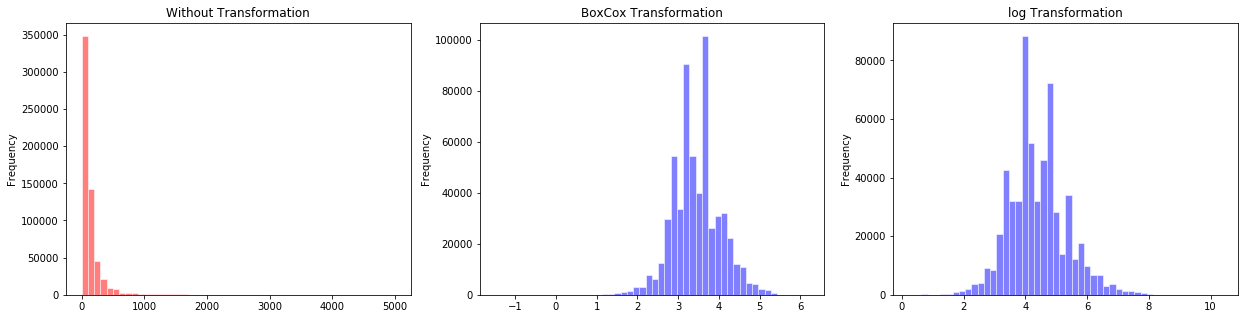

In [49]:
%matplotlib inline
plt.subplot(1, 3, 1)
(train_tran_df.TransactionAmt).plot.hist(bins=50, figsize=(21, 5),color = 'red',alpha = 0.5 ,edgecolor = 'white', range = [0, 5000],title = 'Without Transformation')

plt.subplot(1, 3, 2)
pd.Series(boxcox(train_tran_df.TransactionAmt)[0]).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'BoxCox Transformation')

plt.subplot(1, 3, 3)
np.log(train_tran_df.TransactionAmt+1).plot.hist(bins=50, figsize=(21,5),color = 'blue',alpha = 0.5 ,edgecolor='white',title = 'log Transformation')

plt.show()

In [0]:
#what is productcd affect on fraud
pd.crosstab(train_tran_df.ProductCD,train_tran_df.isFraud).transpose().apply(lambda r: r/r.sum(), axis=0)

ProductCD,C,H,R,S,W
isFraud,,,,,
0,0.883127,0.952338,0.962174,0.941004,0.979601
1,0.116873,0.047662,0.037826,0.058996,0.020399


In [0]:

train_tran_df[numericCols].describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,Transaction_dow,Transaction_hour
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,5902

In [0]:
#drop Columns with more than 70% na data
(train_tran_df.isna().sum()/train_tran_df.shape[0])*100[0]


TransactionID        0.000000
isFraud              0.000000
TransactionDT        0.000000
TransactionAmt       0.000000
ProductCD            0.000000
card1                0.000000
card2                1.512683
card3                0.265012
card4                0.000000
card5                0.721204
card6                0.000000
addr1               11.126427
addr2               11.126427
dist1               59.652352
dist2               93.628374
P_emaildomain        0.000000
R_emaildomain        0.000000
C1                   0.000000
C2                   0.000000
C3                   0.000000
C4                   0.000000
C5                   0.000000
C6                   0.000000
C7                   0.000000
C8                   0.000000
C9                   0.000000
C10                  0.000000
C11                  0.000000
C12                  0.000000
C13                  0.000000
C14                  0.000000
D1                   0.214888
D2                  47.549192
D3        

In [0]:
train_tran_df[categoricalCols] = train_tran_df[categoricalCols].replace({ np.nan:'missing'})
train_tran_df[numericCols] = train_tran_df[numericCols].replace({ np.nan:-1})

KeyboardInterrupt: ignored

In [0]:

Feature= widgets.Dropdown(options= numericCols)

def plotit(Feature):                            
    
    %matplotlib inline
    
    plt.figure(figsize = (10,5))
    sns.scatterplot(x = train_tran_df[Feature],y = train_tran_df.isFraud,hue = train_tran_df.isFraud)

    flush_figures()
                            
interactive(plotit, Feature=Feature)

interactive(children=(Dropdown(description='Feature', options=('TransactionID', 'isFraud', 'TransactionDT', 'T…